<h1 style="text-align: center; 
            font-size: 2em; 
            font-weight: bold; 
            background-color: #ffcc00; 
            padding: 20px;
            color: #000000;
            margin: 20px;
            line-height: 1.5;">
Preprocessing the Images
</h1>

### **Importing the Libraries**

In [112]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from PIL import Image

from deskew import determine_skew
from scipy import ndimage

from skimage.filters import threshold_otsu

### **Making baseline functions**

In [113]:
def read_image(image_file):
    img = cv2.imread(image_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

In [114]:
def image_scalling(img):
    height, width = img.shape[:2]
    if ( height < 350 or width < 350 ) and ( height > 150 or width > 150 ):
        img = cv2.resize(img, None, fx=4, fy=4, interpolation=cv2.INTER_CUBIC)

    elif ( height < 150 or width < 150 ):
        img = cv2.resize(img, None, fx=8, fy=8, interpolation=cv2.INTER_CUBIC)

    else:
        pass
    
    return img

In [115]:
def remove_noise(img):
    img = cv2.medianBlur(img, 5)
    return img

In [116]:
from scipy.ndimage import rotate

def find_score(image,angle):
    data=rotate(image,angle,reshape=False,order=0)
    hist=np.sum(data,axis=1)
    score = np.sum((hist[1:]-hist[:-1])**2)
    return hist,score

def deskew_image(image):
    bin_img=cv2.bitwise_not(image)
    bin_img=cv2.adaptiveThreshold(bin_img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,21,2)
    image=image.reshape(image.shape[0],image.shape[1],1)
    bin_img=bin_img.reshape(bin_img.shape[0],bin_img.shape[1],1)
    delta=1
    limit=5
    angles=np.arange(-limit, limit+delta, delta)
    scores=[]
    for angle in angles:
        hist,score=find_score(bin_img,angle)
        scores.append(score)
    best_score=max(scores)
    best_angle=angles[scores.index(best_score)]
    image = rotate(image,best_angle,reshape=False,order=0)
    return image

In [117]:
def image_invertion(img):
    thresh = threshold_otsu(img)
    if thresh > 127:
        img = cv2.bitwise_not(img)
    return img

In [118]:
def image_sharpening(img):
    # Image Structuring Element
    structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 50))

    imgTopHat = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, structuringElement)
    imgBlackHat = cv2.morphologyEx(img, cv2.MORPH_BLACKHAT, structuringElement)

    imgGrayscalePlusTopHat = cv2.add(img, imgTopHat)
    img = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

    # Image Kernel Sharpening
    kernel_sharpening = np.array([[-1,-1,-1],
                                [-1, 9,-1],
                                [-1,-1,-1]])
    img = cv2.filter2D(img, -1, kernel_sharpening)

    # Remove Noise
    img = cv2.bilateralFilter(img, 11, 17, 17)
    
    # Sharpen Edge
    img = cv2.GaussianBlur(img, (5, 5), 0)
    img = cv2.addWeighted(img, 1.5, img, -0.5, 0)
    
    return img

In [119]:
def erode_image(img):
    kernel = np.ones((3,3), np.uint8)
    img = cv2.erode(img, kernel, iterations=1)
    return img

In [120]:
def otsu_thresholding(img):
    thresh = threshold_otsu(img)
    img = img > thresh
    img = img.astype(np.uint8) * 255
    return img

In [121]:
def image_write(img, image_file, path):
    if not os.path.exists("preprocessed_{}".format(path)):
        os.makedirs("preprocessed_{}".format(path))
    
    cv2.imwrite("preprocessed_{}/{}".format(path, image_file), img)


In [122]:
def image_more_contrast(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    return img

In [123]:
# make result of otsu edge more thinner
# if the text are on black background, use dilate
# if the text are on white background, use erode
def edge_reducing(img):
    # if the background is black
    if np.mean(img) > 127:
        kernel = np.ones((3,3), np.uint8)
        img = cv2.dilate(img, kernel, iterations=2)
    # if the background is white
    else:
        kernel = np.ones((3,3), np.uint8)
        img = cv2.erode(img, kernel, iterations=2)
    return img

In [124]:
def dir_check(path):
    if not os.path.exists(path):
        print("\033[91m{}\033[00m".format("Error: The path is not exist."))
        return False
    
    return True

### **Preprocessing Process**

In [125]:
preprocess_timeline = [
    image_scalling,
    remove_noise,
    deskew_image,
    image_sharpening,
    image_invertion,
    image_more_contrast,
    otsu_thresholding,
    edge_reducing,
]

### **Code Testing**

In [126]:
# create a step by step preprocess plot
def preprocess_image(path, image_name):
    image_file = "{}/{}".format(path, image_name)

    num_of_process = len(preprocess_timeline) + 1
    
    fig, axs = plt.subplots(num_of_process, 1, figsize=(20, 20))
    fig.suptitle('Preprocess Image', 
                 fontsize=20, 
                 fontweight='bold',
                 color='aliceblue',
                 )
    
    img = read_image(image_file)
    axs[0].imshow(img, cmap='gray')
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    for i in range(1, len(preprocess_timeline)+1):
        # Above this process is to make sure the process is not empty
        _temp_preprocess = preprocess_timeline[i-1](img)
        img = _temp_preprocess
        
        axs[i].imshow(img, cmap='gray')
        axs[i].set_title(preprocess_timeline[i-1].__name__)
        axs[i].axis('off')
        
    fig.tight_layout(pad=3.0, w_pad=0.5, h_pad=1.0)

    for ax in axs.flat:
        ax.set_title(ax.get_title(), fontweight='semibold', fontsize='x-large')
        ax.label_outer()
    
    plt.subplots_adjust(top=0.95)

    plt.show()

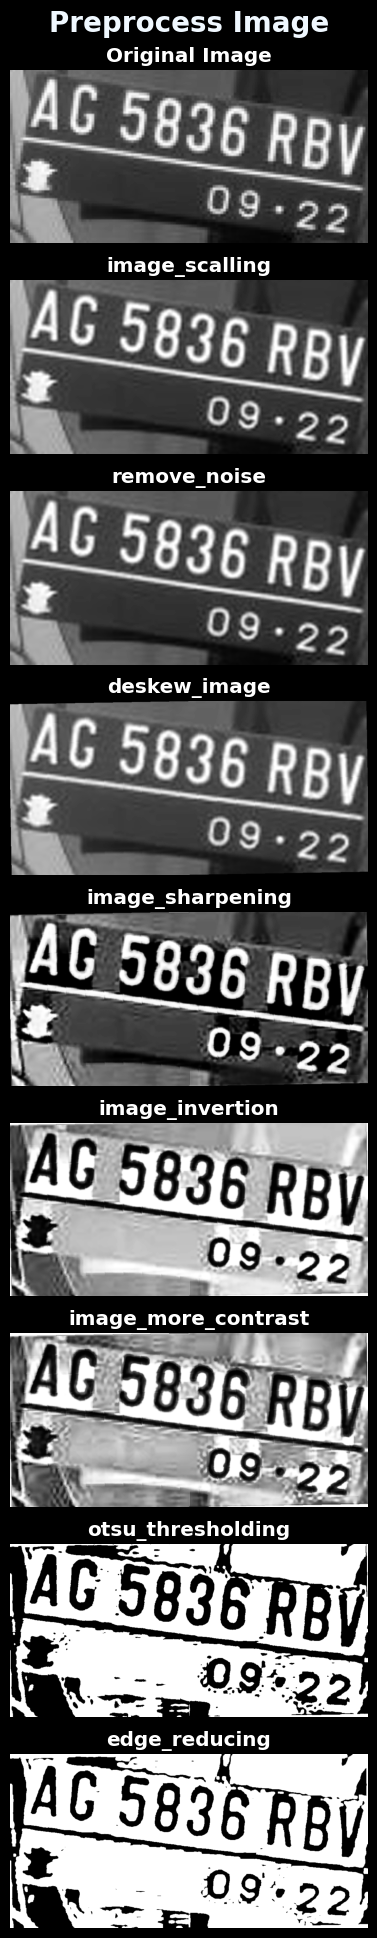

In [127]:
which_folder = "../data/train_data"
which_image = "DataTrain762.png"

if (dir_check(which_folder)):
    preprocess_image(which_folder, which_image)

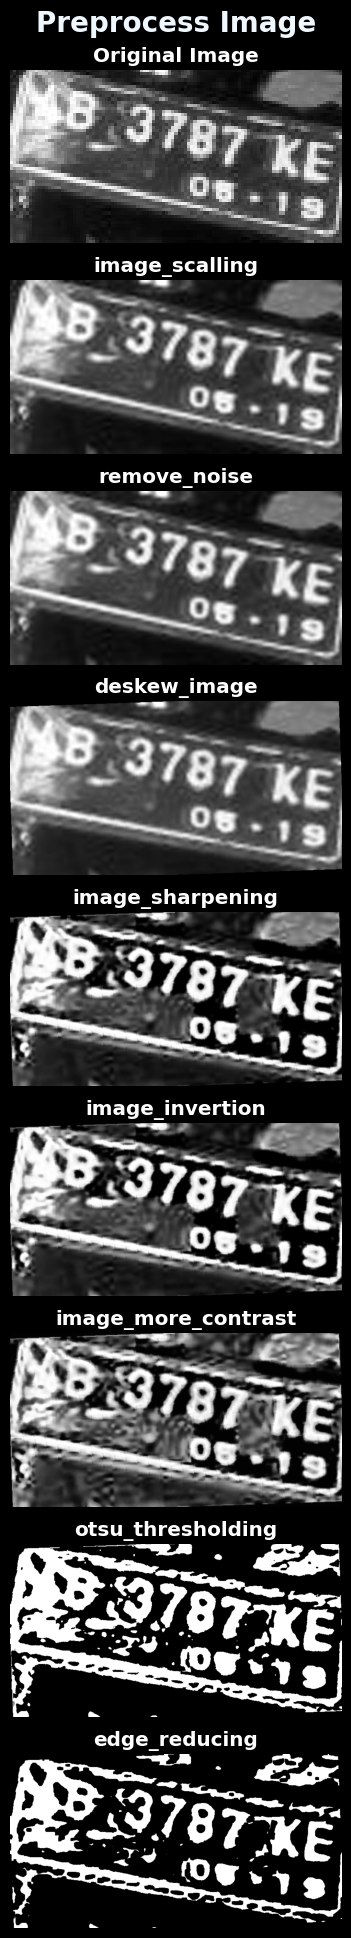

In [128]:
which_folder = "../data/test_data"
which_image = "DataTest85.png"

if (dir_check(which_folder)):
    preprocess_image(which_folder, which_image)

### Preprocessed Iteration

In [129]:
def iter_preprocess_image(path, image_name):
    image_file = "{}/{}".format(path, image_name)

    img = read_image(image_file)

    for i in range(1, len(preprocess_timeline)+1):
        # Above this process is to make sure the process is not empty
        _temp_preprocess = preprocess_timeline[i-1](img)
        
        img = _temp_preprocess

    image_write(img, image_name, path)

In [130]:
from tqdm import tqdm

def preprocess_all_image(path, which_folder):
    os.chdir("../data")
    if not os.path.exists(path):
        print("\033[91m{}\033[00m".format("Error: The path is not exist."))
        return False
    
    print("\033[1;31;40m {} \n".format(which_folder))

    total_file = len(os.listdir(path)) - 1

    progress_bar = tqdm(total=total_file)
    progress_bar.set_description("Preprocessing Data")

    for image_name in os.listdir(path):
        if image_name[-4:] == ".png":
            progress_bar.update(1)
            iter_preprocess_image(path, image_name)

    progress_bar.close()
    os.chdir("../src")


# print("\n")
# print("-" * 50)
# print("\n")

# print("\033[1;31;40m Test Data \n")
# total_file = len(os.listdir("../data/test_data")) - 1

# progress_bar = tqdm(total=total_file)
# progress_bar.set_description("Preprocessing Test Data")

# for image_name in os.listdir("../data/test_data"):
#     if image_name[-4:] == ".png":
#         progress_bar.update(1)
#         iter_preprocess_image("test_data", image_name)

# progress_bar.close()

In [131]:
preprocess_all_image("train_data", "Train Data")

 Train Data 



Preprocessing Data:   0%|          | 0/800 [00:00<?, ?it/s]

Preprocessing Data: 100%|██████████| 800/800 [13:06<00:00,  1.02it/s]


In [132]:
preprocess_all_image("test_data", "Test Data")

 Test Data 



Preprocessing Data: 100%|██████████| 100/100 [02:50<00:00,  1.70s/it]
